In [349]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import time

In [350]:
def tails(x):
    return 1-x

def projectBasis(someAxis, theta, r = 0.8, theta_width = 0.2, r_width = 0.6):
    someAxis.add_patch(Rectangle((theta - 0.5*theta_width, r - 0.5*r_width), theta_width, r_width,alpha=1,fill=None))

In [366]:
class Singlet:
    def __init__(self, N = 1000,RPM = 1):
        theta = np.linspace(0,2*np.pi,N)
        r = np.linspace(.6,1,2)
        self.rg, self.tg = np.meshgrid(r,theta)
        self.epoch = time.time() # time t = 0
        self.Afunc = lambda theta: np.cos(theta + 2*np.pi*RPM/60 * (time.time() - self.epoch))**2
        self.Bfunc = lambda theta: np.cos(theta + 2*np.pi*RPM/60 * (time.time() - self.epoch))**2
        self.ATfunc = lambda theta: 1-np.cos(theta + 2*np.pi*RPM/60 * (time.time() - self.epoch))**2
        self.BTfunc = lambda theta: 1-np.cos(theta + 2*np.pi*RPM/60 * (time.time() - self.epoch))**2
        self.RPM = RPM
        self.superposition = True
        self.collapsed = False
        self.figure = None
    def measure_Alice(self,polarizer_angle):
        # Draws the basis rectangle that determines superposition collapse
        projectBasis(self.figure.get_axes()[1],polarizer_angle)
        projectBasis(self.figure.get_axes()[3],polarizer_angle)

    def collapse_Alice(self,polarizer_angle):
        # Redefines underlying probability functions Afunc & Bfunc to reflect superposition collapse
        # Probability of transmission through beamsplitter is Afunc(polarizer_angle)
        transmitted = np.random.uniform(1) < self.Afunc(polarizer_angle)
        if transmitted:
            self.ATfunc = lambda theta:np.nan*np.ones(theta.shape)
            self.BTfunc = lambda theta:np.nan*np.ones(theta.shape)

            self.Afunc = lambda theta: 1*np.ones(theta.shape)
            print('Head sides selected')
            if self.superposition:
                self.Bfunc = lambda theta: np.cos(theta - polarizer_angle)**2 # Collapse superposition
                self.superposition = False
            
        if not(transmitted):
            self.Afunc = lambda theta:np.nan*np.ones(theta.shape)
            self.Bfunc = lambda theta:np.nan*np.ones(theta.shape)
            self.ATfunc = lambda theta: 0*np.ones(theta.shape)
            print('Tail sides selected')
            if self.superposition:
                self.BTfunc = lambda theta: np.cos(theta - polarizer_angle + np.pi/2)**2 # Collapse superposition
                self.superposition = False
        return transmitted
    
    def plotState(self):
        # Initializes figure with a bunch of commands from scratch.
        if self.figure == None:
            # make a new figure
            fig = plt.figure(figsize=(10,10))
        else:
            # draw on top of the previous
            fig = self.figure
        current_time = time.time() - self.epoch
        plt.title(current_time)
        print(time.time)
        Aax = fig.add_subplot(221, polar=True)
        Aax.pcolormesh(self.tg, self.rg,self.Afunc(self.tg),cmap='jet')  #plot the colormesh on axis with colormap
        Aax.set_theta_zero_location('N', 0)
        Aax.text(0,0,"A Heads",fontsize=18,horizontalalignment='center',verticalalignment='center')
        
        
        Bax = fig.add_subplot(222, polar=True)
        Bax.pcolormesh(self.tg, self.rg,self.Bfunc(self.tg),cmap='jet')  #plot the colormesh on axis with colormap
        Bax.set_theta_zero_location('N', 0)
        Bax.text(0,0,"B Heads",fontsize=18,horizontalalignment='center',verticalalignment='center')

        AaxT = fig.add_subplot(223, polar=True)
        AaxT.pcolormesh(self.tg, self.rg,self.ATfunc(self.tg),cmap='jet')  #plot the colormesh on axis with colormap
        AaxT.set_theta_zero_location('N', 0)
        AaxT.text(0,0,"A Tails",fontsize=18,horizontalalignment='center',verticalalignment='center')

        BaxT = fig.add_subplot(224, polar=True)
        BaxT.pcolormesh(self.tg, self.rg,self.BTfunc(self.tg),cmap='jet')  #plot the colormesh on axis with colormap
        BaxT.set_theta_zero_location('N', 0)
        BaxT.text(0,0,"B Tails",fontsize=18,horizontalalignment='center',verticalalignment='center')
        self.figure = fig

psi = Singlet()


<built-in function time>


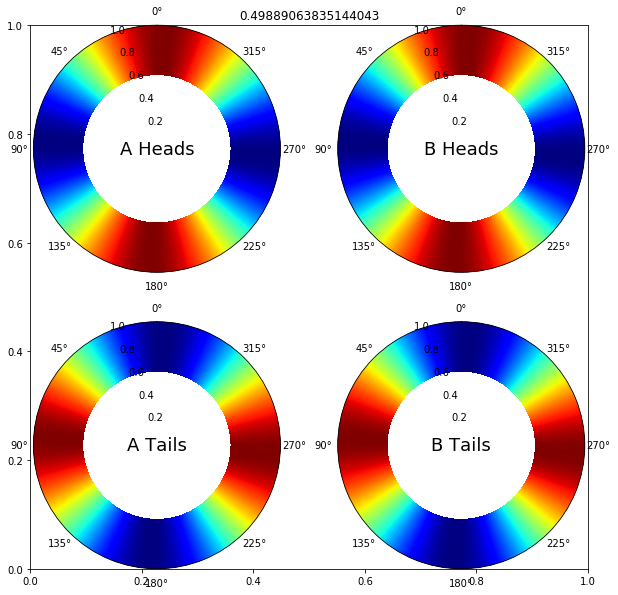

In [367]:
psi.plotState()

In [368]:
psi.measure_Alice(22.5 * np.pi/180)

<built-in function time>


/home/calvin/anaconda3/envs/py3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


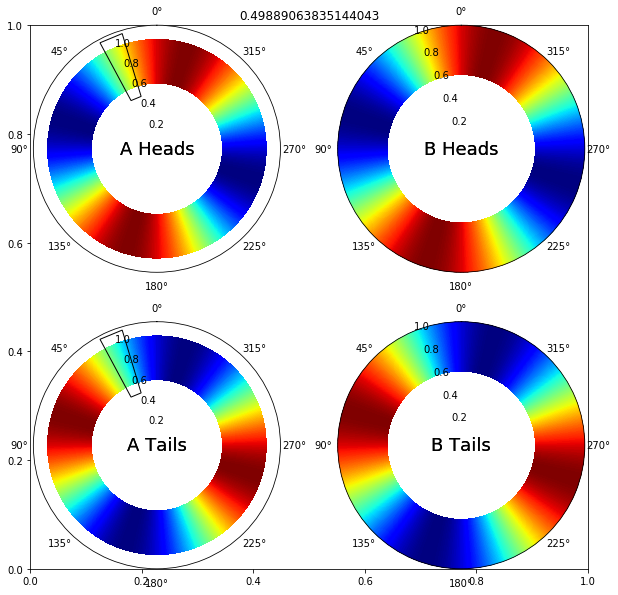

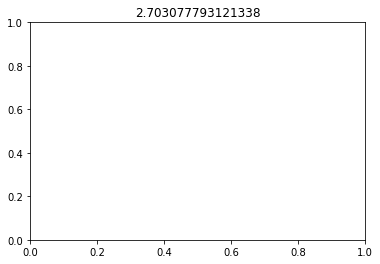

In [369]:
psi.plotState()
psi.figure

<built-in function time>


/home/calvin/anaconda3/envs/py3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


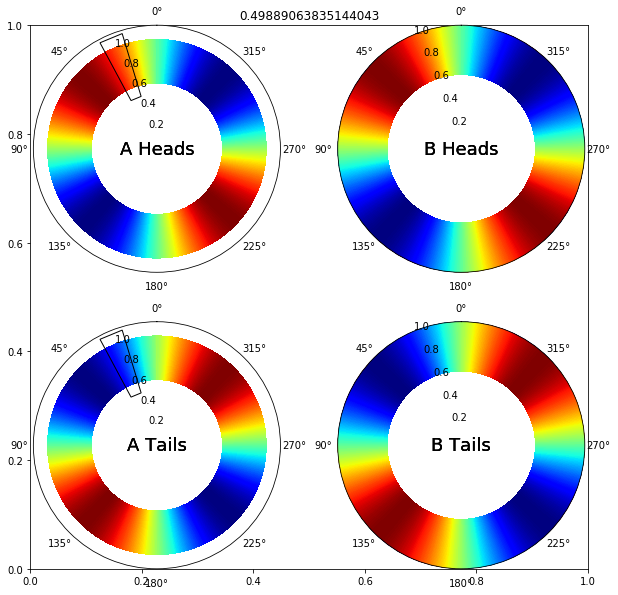

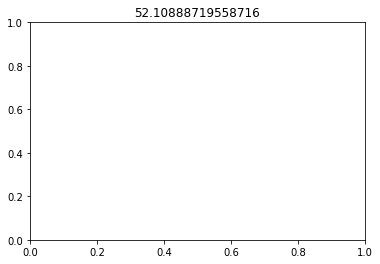

In [371]:
psi.plotState()
psi.figure

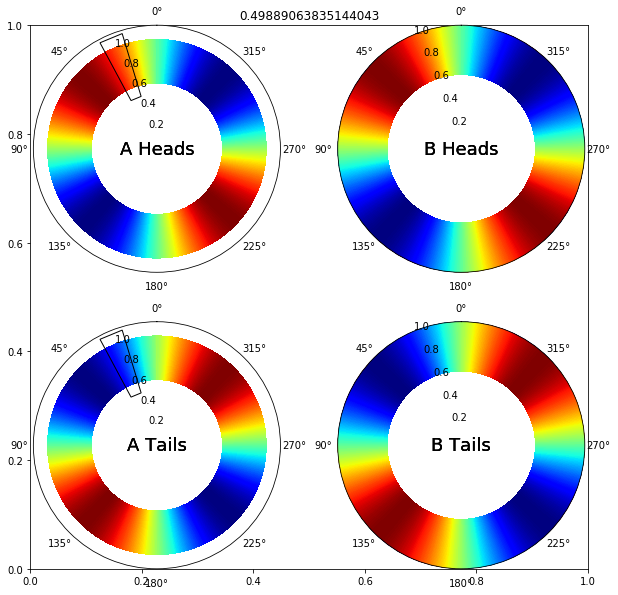

In [372]:
psi.figure

In [273]:
fig.get_axes()[0].plot([.25,1.5],[2,3])

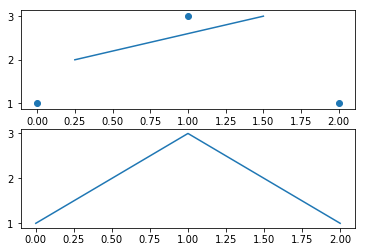

In [274]:
fig